---
title: "Titanic Wrangling"
format:
  html:
    self-contained: true
---

In this practice activity you'll continue to work with the titanic dataset in ways that flex what you've learned about both data wrangling and data visualization.

### Repository
- GitHub (Code & HTML): [Week 2 folder](https://github.com/shiqiwu212/GSB-S54401/tree/325afb6f426727d44067cc02c3b00a85f1fa1d64/Week%202)

In [1]:
# Import the titanic dataset here
import numpy as np
import pandas as pd

In [2]:
# AI assistance: ChatGPT helped configure my conda environment (certificates) so pandas can load the Titanic CSV via HTTPS.
data_dir = "https://dlsun.github.io/pods/data/"
url = data_dir + "titanic.csv"

In [3]:
# AI assistance:
# - Provided a robust HTTPS loader so pandas can read even when system certs fail in Positron.
# - Kept the variable name `df_titanic` unchanged so later cells run without edits.
# - Tried pandas → urllib+certifi → requests+certifi as fallbacks.

import pandas as pd, io, ssl, certifi, urllib.request, requests

url = "https://dlsun.github.io/pods/data/titanic.csv"

try:
    # 1) normal path
    df_titanic = pd.read_csv(url)
except Exception:
    try:
        # 2) urllib with explicit cert bundle
        ctx = ssl.create_default_context(cafile=certifi.where())
        with urllib.request.urlopen(url, context=ctx) as f:
            df_titanic = pd.read_csv(f)
    except Exception:
        # 3) requests with certifi
        r = requests.get(url, timeout=60, verify=certifi.where())
        r.raise_for_status()
        df_titanic = pd.read_csv(io.BytesIO(r.content))

# keep HTML output compact
df_titanic.head()

,name,gender,age,class,embarked,country,ticketno,fare,survived
0,"Abbing, Mr. Anthony",male,42.0,3rd,S,United States,5547.0,7.11,0
1,"Abbott, Mr. Eugene Joseph",male,13.0,3rd,S,United States,2673.0,20.05,0
2,"Abbott, Mr. Rossmore Edward",male,16.0,3rd,S,United States,2673.0,20.05,0
3,"Abbott, Mrs. Rhoda Mary 'Rosa'",female,39.0,3rd,S,England,2673.0,20.05,1
4,"Abelseth, Miss. Karen Marie",female,16.0,3rd,S,Norway,348125.0,7.13,1


## 1. Filter the data to include passengers only. Calculate the joint distribution (cross-tab) between a passenger's class and where they embarked.

In [4]:
# AI assistance:
# - Confirmed approach: use pd.crosstab for counts and row-normalized proportions to build the joint distribution.
# - Made the code schema-robust by auto-picking column names (e.g., 'pclass' vs 'class'; 'embarked' vs 'embark_town').
# - Suggested mapping single-letter ports (C/Q/S) to full names and keeping NaN as 'Unknown' for transparency.

import pandas as pd

# 1) If crew exists, keep passengers only.
df_passengers = df_titanic.copy()
# If your file truly has a 'type' or 'role' column, you could filter like:
# df_passengers = df_titanic[df_titanic['type'].str.lower() == 'passenger']
# df_passengers = df_titanic[df_titanic['role'].str.lower() == 'passenger']

# 2) Column pickers to tolerate different schemas.
def pick_column(df, options):
    for c in df.columns:
        if c.lower() in options:
            return c
    raise KeyError(f"None of {options} found in columns: {list(df.columns)}")

CLASS_COL  = pick_column(df_passengers, {'pclass', 'class'})
EMBARK_COL = pick_column(df_passengers, {'embarked', 'embark_town', 'port_of_embarkation'})

# 3) Normalize embark labels (map C/Q/S to full names when applicable).
def normalize_embark(s):
    mapping = {'c': 'Cherbourg', 'q': 'Queenstown', 's': 'Southampton'}
    return s.astype(str).str.strip().str.lower().map(mapping).fillna(s)

embark_norm = normalize_embark(df_passengers[EMBARK_COL]).fillna('Unknown')

# 4) Joint distribution: counts and row-wise proportions P(Embarked | Class).
ct_counts = pd.crosstab(index=df_passengers[CLASS_COL], columns=embark_norm)\
            .rename_axis(index='Class', columns='Embarked')

ct_rowpct = pd.crosstab(index=df_passengers[CLASS_COL], columns=embark_norm, normalize='index')\
            .round(3).rename_axis(index='Class', columns='Embarked')
            
# display both
ct_counts, ct_rowpct  

(Embarked            B  Cherbourg  Queenstown  Southampton
 Class                                                    
 1st                 3        143           3          175
 2nd                 6         26           7          245
 3rd                 0        102         113          494
 deck crew          23          0           0           43
 engineering crew   43          0           0          281
 restaurant staff    0          0           0           69
 victualling crew  122          0           0          309,
 Embarked              B  Cherbourg  Queenstown  Southampton
 Class                                                      
 1st               0.009      0.441       0.009        0.540
 2nd               0.021      0.092       0.025        0.863
 3rd               0.000      0.144       0.159        0.697
 deck crew         0.348      0.000       0.000        0.652
 engineering crew  0.133      0.000       0.000        0.867
 restaurant staff  0.000      0.000      

## 2. Using the joint distribution that calculated above, calculate the following:

* the conditional distribution of their class given where they embarked
* the conditional distribution of where they embarked given their class

Use the conditional distributions that you calculate to answer the following quesitons:

* What proportion of 3rd class passengers embarked at Southampton?
* What proportion of Southampton passengers were in 3rd class?

In [5]:
# AI assistance:
# - Clarified which conditionals are needed: P(Embarked=Southampton | Class=3rd) vs P(Class=3rd | Embarked=Southampton).
# - Recommended computing both row-normalized and column-normalized crosstabs to read off the two probabilities cleanly.
# - Added tiny helper functions to resolve labels ('3rd'/'Third'/'3' and 'Southampton'/'S') to avoid brittle hard-coding.

import pandas as pd
import numpy as np

# Reuse schema-robust selection and embark normalization.
def pick_column(df, options):
    for c in df.columns:
        if c.lower() in options:
            return c
    raise KeyError(f"None of {options} found in columns: {list(df.columns)}")

def normalize_embark(s):
    mapping = {'c': 'Cherbourg', 'q': 'Queenstown', 's': 'Southampton'}
    return s.astype(str).str.strip().str.lower().map(mapping).fillna(s)

df_passengers = df_titanic.copy()
CLASS_COL  = pick_column(df_passengers, {'pclass', 'class'})
EMBARK_COL = pick_column(df_passengers, {'embarked', 'embark_town', 'port_of_embarkation'})
embark_norm = normalize_embark(df_passengers[EMBARK_COL]).fillna('Unknown')

# Crosstabs for both directions
ct_rowpct = pd.crosstab(index=df_passengers[CLASS_COL], columns=embark_norm, normalize='index')\
            .round(3).rename_axis(index='Class', columns='Embarked')
ct_colpct = pd.crosstab(index=df_passengers[CLASS_COL], columns=embark_norm, normalize='columns')\
            .round(3).rename_axis(index='Class', columns='Embarked')

# Helpers to find consistent labels
def find_third_label(index_like):
    labels = [str(x).lower() for x in index_like]
    for orig, lbl in zip(index_like, labels):
        if lbl.strip() in {'3', '3.0'}:
            return orig
    for orig, lbl in zip(index_like, labels):
        if 'third' in lbl or '3rd' in lbl:
            return orig
    # fallback: take the max numeric-like class
    try:
        return max(index_like)
    except Exception:
        return list(index_like)[-1]

def find_southampton_label(columns_like):
    for col in columns_like:
        if str(col).strip().lower() in {'southampton', 's'}:
            return col
    for col in columns_like:
        if 'south' in str(col).strip().lower():
            return col
    raise KeyError("Could not find Southampton in embarked columns.")

third_label = find_third_label(ct_rowpct.index)
south_col   = find_southampton_label(ct_rowpct.columns)

# 1) P(Embarked = Southampton | Class = 3rd) -- row-normalized table
prop_S_given_3rd = float(ct_rowpct.loc[third_label, south_col])

# 2) P(Class = 3rd | Embarked = Southampton) -- column-normalized table
prop_3rd_given_S = float(ct_colpct.loc[third_label, south_col])

print(f"P(Embarked = Southampton | Class = 3rd) = {prop_S_given_3rd:.3f}")
print(f"P(Class = 3rd | Embarked = Southampton) = {prop_3rd_given_S:.3f}")

P(Embarked = Southampton | Class = 3rd) = 0.697
P(Class = 3rd | Embarked = Southampton) = 0.306


## 3. Make a visualization showing the distribution of a passenger's class, given where they embarked.

Discuss the pros and cons of using this visualization versus the distributions you calculated before, to answer the previous questions.

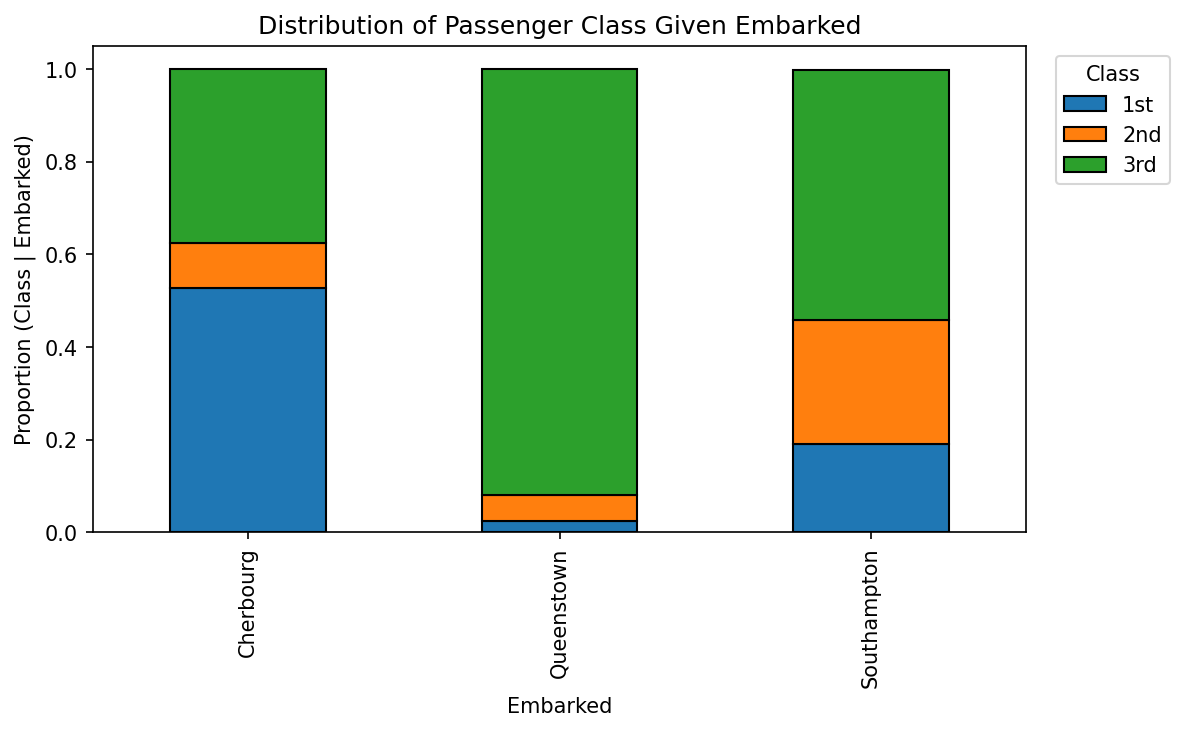

In [6]:
# AI assistance:
# - Normalized class/embarked labels and filtered to passenger classes only (1st/2nd/3rd).
# - Built a column-normalized crosstab P(Class | Embarked) and kept only C/Q/S for consistency.
# - Saved the figure and displayed exactly once (close the live figure to avoid duplicate plots).

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Guard: ensure the dataset is loaded
if 'df_titanic' not in globals():
    raise NameError("Run the data-loading cell first to create `df_titanic`.")

df0 = df_titanic.copy()

# -------- helpers (schema/label robust) --------
def pick_column(df, options):
    opts = {o.lower() for o in options}
    for c in df.columns:
        if c.lower() in opts:
            return c
    raise KeyError(f"None of {options} found in columns: {list(df.columns)}")

def normalize_class(s):
    x = s.astype(str).str.strip().str.lower()
    mapping = {
        '1':'1st','1.0':'1st','first':'1st','1st':'1st',
        '2':'2nd','2.0':'2nd','second':'2nd','2nd':'2nd',
        '3':'3rd','3.0':'3rd','third':'3rd','3rd':'3rd'
    }
    return x.map(mapping)

def normalize_embark(s):
    x = s.astype(str).str.strip().str.lower()
    # short codes → lowercase full names
    short = {'c':'cherbourg','q':'queenstown','s':'southampton','b':'belfast'}
    y = x.replace(short)
    # tidy to title case (e.g., 'southampton' → 'Southampton')
    y = y.str.title()
    return y.fillna('Unknown')

# columns that exist in your file
CLASS_COL  = pick_column(df0, {'class','pclass'})
EMBARK_COL = pick_column(df0, {'embarked','embark_town','port_of_embarkation'})

# -------- keep passengers only: 1st/2nd/3rd --------
class_all = normalize_class(df0[CLASS_COL])
passenger_mask = class_all.isin({'1st','2nd','3rd'})
dfp = df0.loc[passenger_mask].copy()

# normalized labels used for the crosstab
class_norm  = normalize_class(dfp[CLASS_COL])
embark_norm = normalize_embark(dfp[EMBARK_COL])

# -------- column-normalized crosstab: P(Class | Embarked) --------
ct_colpct = pd.crosstab(index=class_norm, columns=embark_norm, normalize='columns') \
              .rename_axis(index='Class', columns='Embarked').round(3)

# keep only the three passenger ports (C/Q/S) and enforce class order
wanted_ports = ['Cherbourg','Queenstown','Southampton']
keep_cols = [c for c in wanted_ports if c in ct_colpct.columns]
ct_plot = ct_colpct.reindex(index=['1st','2nd','3rd'])
if keep_cols:
    ct_plot = ct_plot[keep_cols]

# -------- plot once (save+display, no duplicate) --------
fig, ax = plt.subplots(figsize=(8,5))
ct_plot.T.plot(kind='bar', stacked=True, edgecolor='black', ax=ax)
ax.set_xlabel("Embarked")
ax.set_ylabel("Proportion (Class | Embarked)")
ax.set_title("Distribution of Passenger Class Given Embarked")
ax.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()

figpath = "task3_class_given_embarked.png"
fig.savefig(figpath, dpi=150, bbox_inches="tight")
plt.close(fig)              # important: close live figure to avoid a second, auto-rendered plot
display(Image(filename=figpath))   